[[-1. -1. -1. -1. -1. -1.]]
(40,)


Training with Numerical gradients: 100%|██████████| 100/100 [00:27<00:00,  3.69it/s]


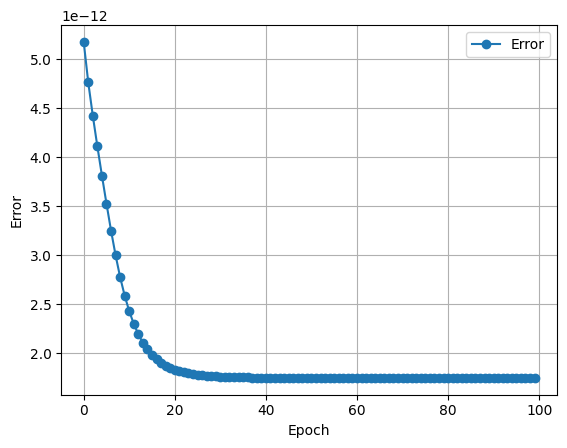

(40,)


In [6]:
import jax
import jax.numpy as jnp
from jax import grad
from tqdm import trange

import jax.numpy as jnp
import json
import os
import sys
from skopt.space import Space
from skopt.sampler import Halton
from jax import jacfwd

# Special Transform Functions
from jax import grad, jit, vmap, pmap
import jax
from jax import jit

from jax._src.lax.utils import (
    _argnum_weak_type,
    _input_dtype,
    standard_primitive,)
from jax._src.lax import lax

from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import prk_method.prk_for_optimization as IRK4
import Important_functions.Transformation_Functions as TFunctions
import Important_functions.Convert_1D2D as convert
import Important_functions.Energy_Error as EE

A1 = A2 = jnp.array([
     [0., 0., 0., 0.],
     [5/24, 1/3, -1/24, 0.],
     [1/6, 2/3, 1/6, 0.],
     [0., 0., 0., 0.]])
B1 = B2 = jnp.array([1/6, 2/3, 1/6, 0.])


## Making the Halton code

spacedim = [(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5) ]

space = Space(spacedim)

halton = Halton()
n = 1

halton_sequence = halton.generate(space, n)
halton_sequence = jnp.array(halton_sequence)

## Dividing in training and validation set. 100 for the training set and 50 for the validation set. 
# validation_halton = halton_sequence[100:150]
halton_sequence = halton_sequence #[:100]
print(halton_sequence)

# print(len(halton_sequence))
# print(len(validaton_halton))



# Assuming the necessary functions like IRK4.find_error, convert.Convert_toOneD, and matrix operations are defined


# Initial A1D
A1D = convert.Convert_toOneD(A1, A2, B1, B2)
print(A1D.shape)

# Learning rate
learning_rate = 0.0001

# Single Halton sequence element
halton_element = halton_sequence[0]

# Function to compute error
def compute_error(A1D, halton_element):
    return IRK4.find_error(A1D, halton_element)

# Gradient function
grad_fn = jax.jacfwd(compute_error)

# Central Difference method :
def numerical_gradient(A1D, halton_element, epsilon=1e-5):
    numerical_gradients = jnp.zeros_like(A1D)

    for i in range(len(A1D)):
        A1D_plus = A1D.at[i].set(A1D[i] + epsilon)
        A1D_minus = A1D.at[i].set(A1D[i] - epsilon)
        # numerical_gradients[i] = (compute_error(A1D_plus, halton_element) - compute_error(A1D_minus, halton_element)) / (2 * epsilon)
        
        numerical_gradients = numerical_gradients.at[i].set((compute_error(A1D_plus, halton_element) - compute_error(A1D_minus, halton_element)) / (2 * epsilon))

    return numerical_gradients

# Compute numerical gradients
A1D_initial = convert.Convert_toOneD(A1, A2, B1, B2)
numerical_gradients = numerical_gradient(A1D_initial, halton_element)

# Training loop
error_list_numerical = []
A1D_numerical = A1D_initial.copy()

for epoch in trange(100, desc="Training with Numerical gradients"):
    # Compute the gradient for the current parameters using the numerical method
    gradients = numerical_gradient(A1D_numerical, halton_element)
    
    # Update the parameters using gradient descent
    A1D_numerical = A1D_numerical - learning_rate * gradients
    
    # Compute the error for the current parameters
    current_error = compute_error(A1D_numerical, halton_element)
    
    # Store the error for plotting
    error_list_numerical.append(current_error)

# Plot the error
import matplotlib.pyplot as plt
error_list_numerical = jnp.array(error_list_numerical)
plt.plot(range(len(error_list_numerical)), error_list_numerical, label="Error", marker='o')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

# Print final shape of A1D
print(A1D.shape)
